## Importing the relevant packages

In [11]:
# Importar la biblioteca pandas con el alias 'pd' para el manejo de datos
import pandas as pd
# Importar la biblioteca numpy con el alias 'np' para operaciones numéricas
import numpy as np
# Importar la biblioteca matplotlib.pyplot con el alias 'plt' para la visualización de gráficos
import matplotlib.pyplot as plt
# Importar submódulos específicos de la biblioteca statsmodels relacionados con análisis de series temporales
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
# Importar la clase ARIMA del submódulo 'arima_model' de la biblioteca statsmodels
from statsmodels.tsa.arima_model import ARIMA
# Importar la distribución chi-cuadrado desde scipy.stats.distributions
from scipy.stats.distributions import chi2 
# Importar la función sqrt (raíz cuadrada) desde la biblioteca math
from math import sqrt
# Importar la biblioteca seaborn con el alias 'sns' para mejorar la apariencia de gráficos
import seaborn as sns
# Configurar la configuración de estilo y apariencia predeterminada de seaborn
sns.set()

## Importing the Data and Pre-processing 

In [12]:
# Cargar datos desde un archivo CSV
raw_csv_data = pd.read_csv("df_comp.csv") 
# Crear una copia del DataFrame para el procesamiento
df_comp=raw_csv_data.copy()
# Convertir la columna 'date' a formato de fecha y corregir errores si los hay
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True,errors='coerce')
# Establecer la columna 'date' como el índice del DataFrame
df_comp.set_index(['date'], inplace=True)
# Eliminar duplicados en el índice, manteniendo solo la primera ocurrencia
df_comp = df_comp[~df_comp.index.duplicated(keep='first')]
# Reorganizar los datos para que tengan una frecuencia comercial ('b' representa días hábiles)
df_comp=df_comp.asfreq('b')
# Rellenar los valores faltantes hacia adelante usando el último valor conocido
df_comp=df_comp.fillna(method='ffill')

In [13]:
# Crear una nueva columna 'market_value' en el DataFrame 'df_comp' y copiar los valores de la columna 'ftse' en ella
df_comp['market_value']=df_comp.ftse

In [14]:
# Suprimir advertencias para mejorar la limpieza de la salida en la consola
import warnings
warnings.filterwarnings("ignore")

In [15]:
#del df_comp['spx']
#del df_comp['dax']
#del df_comp['ftse']
#del df_comp['nikkei']
# Dividir el DataFrame en conjuntos de entrenamiento y prueba
size = int(len(df_comp)*0.8)# Tamaño del conjunto de entrenamiento (80% de los datos)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [16]:

# Función para realizar una prueba de razón de verosimilitud (LLR)
# entre dos modelos, mod_1 y mod_2, con un grado de libertad (DF) predeterminado de 1.
# La función calcula el estadístico de prueba LR y devuelve el valor p correspondiente.

def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf # Log-verosimilitud del primer modelo
    L2 = mod_2.llf # Log-verosimilitud del segundo modelo
    LR = (2*(L2-L1)) # Estadístico de prueba LR    
    p = chi2.sf(LR, DF).round(3) # Valor p calculado a partir de la distribución chi-cuadrado
    return p

## Creating Returns

In [17]:
# Esta línea de código calcula el retorno diario de un activo financiero a partir de su serie de precios de mercado y lo almacena en una nueva columna 'returns'.
# Útil para el análisis financiero y económico, ya que los retornos diarios son una medida importante para evaluar el rendimiento y la volatilidad de los activos financieros.

df['returns'] = df.market_value.pct_change(1)*100

## ARIMA(1,1,1)

In [18]:
# Importación de la clase ARIMA del módulo statsmodels.tsa.arima.model
from statsmodels.tsa.arima.model import ARIMA

# Crear un modelo ARIMA(1,1,1) utilizando la serie temporal 'df.market_value'
model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order=(1,1,1))
# Ajustar el modelo ARIMA al conjunto de datos y guardar los resultados
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()

# Muestro un resumen de los resultados
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8065.140
Date:                Fri, 13 Oct 2023   AIC                          16136.280
Time:                        15:10:55   BIC                          16151.546
Sample:                    03-12-2018   HQIC                         16142.031
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6493      0.019     34.607      0.000       0.613       0.686
ma.L1         -0.9256      0.011    -84.084      0.000      -0.947      -0.904
sigma2      4.117e+04    547.728     75.169      0.000    4.01e+04    4.22e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):             34007.98
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Residuals of the ARIMA(1,1,1)

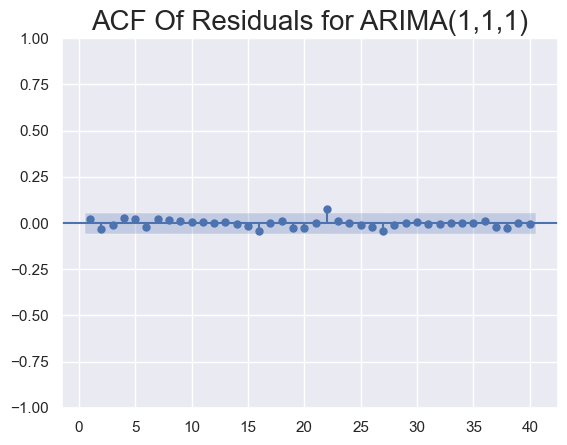

In [19]:
#Se crea una nueva columna llamada 'res_ar_1_i_1_ma_1' en el DataFrame, a partir de los residuos del modelo ARIMA (1,1,1)
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
#Se crea el gráfico de la función de autocorrelación (ACF) de los residuos del modelo ARIMA
sgt.plot_acf(df.res_ar_1_i_1_ma_1, zero = False, lags = 40)
#Este comando se utiliza para establecer el título del gráfico
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
#Muestra el gráfico ACF
plt.show()

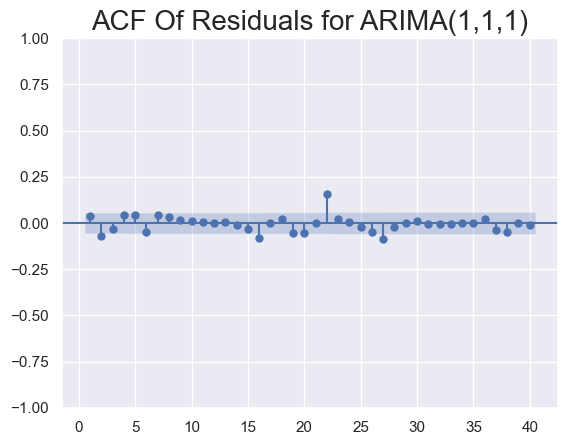

In [20]:
#Se crea una nueva columna llamada 'res_ar_1_i_1_ma_1' en el DataFrame, a partir de los residuos del modelo ARIMA (1,1,1), por último se copia todos los valores de los residuos en la nueva columna
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
#Se crea el gráfico de la función de autocorrelación (ACF) de los residuos del modelo ARIMA
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
#Este comando se utiliza para establecer el título del gráfic
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
#Muestra el gráfico ACF
plt.show()

## Higher-Lag ARIMA Models

In [21]:
#Se ajusta a un modelo ARIMA(1,1,2):
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
#Se ajusta a un modelo ARIMA(1,1,3):
model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
#Se ajusta a un modelo ARIMA(2,1,1):
model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
#Se ajusta a un modelo ARIMA(3,1,1):
model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
#Se ajusta a un modelo ARIMA(3,1,2):
model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_params=[0, 0, 0, 0, 0, 0])


In [22]:
#Los siguientes códigos sirven para mostrar las métricas de evaluación de los modelos ARIMA en fucnión de la verosimilitud (LL) y el criterio Akaike (AIC)
print("ARIMA(1,1,1):  \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

ARIMA(1,1,1):  	 LL =  -8065.14022404698 	 AIC =  16136.28044809396
ARIMA(1,1,2):  	 LL =  -8062.236115887372 	 AIC =  16132.472231774744
ARIMA(1,1,3):  	 LL =  -8061.597837217676 	 AIC =  16133.195674435352
ARIMA(2,1,1):  	 LL =  -8062.571828187791 	 AIC =  16133.143656375581
ARIMA(3,1,1):  	 LL =  -8061.28130756905 	 AIC =  16132.5626151381
ARIMA(3,1,2):  	 LL =  0.0 	 AIC =  12.0


In [23]:
#Este código nos ayuda a realizar una prueba de razón de verosimilitud (LLR) entre dos modelos ARIMA y luego mostrar el p-value.
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_2, results_ar_1_i_1_ma_3)))


LLR test p-value = 0.259


In [24]:
##Este código nos ayuda a realizar una prueba de razón de verosimilitud (LLR) entre dos modelos ARIMA con un grado de libertad especificado (DF = 2) y muestra el p-value.
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_1, results_ar_1_i_1_ma_3, DF = 2)))


LLR test p-value = 0.029


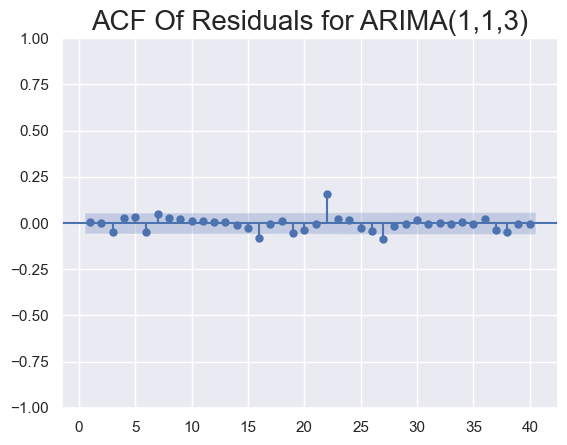

In [25]:
# Calcular los residuos del modelo ARIMA(1,1,3) y almacenarlos en 'df['res_ar_1_i_1_ma_3']'
df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid
# Generar y mostrar el gráfico de la función de autocorrelación (ACF) de los residuos
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], zero = False, lags = 40)
# Establecer un título para el gráfico
plt.title("ACF Of Residuals for ARIMA(1,1,3)", size=20)
# Mostrar el gráfico
plt.show()

In [26]:
# Definir y ajustar un modelo ARIMA(5,1,1) a la serie temporal de los valores de mercado
model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5, 1, 1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()
# Definir y ajustar un modelo ARIMA(6,1,3) a la serie temporal de los valores de mercado
model_ar_6_i_1_ma_3 = ARIMA(df.market_value, order=(6, 1, 3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit()


In [27]:
#Muestra un resumen detallado de los resultados ARIMA (5,1,1)
results_ar_5_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8059.052
Date:                Fri, 13 Oct 2023   AIC                          16132.104
Time:                        15:11:08   BIC                          16167.723
Sample:                    03-12-2018   HQIC                         16145.523
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7038      0.021     34.110      0.000       0.663       0.744
ar.L2         -0.0852      0.019     -4.483      0.000      -0.122      -0.048
ar.L3          0.0236      0.020      1.160      0.246      -0.016       0.063
ar.L4          0.0641      0.020      3.140      0.002       0.024       0.104
ar.L5          0.0040      0.027      0.149      0.881      -0.048       0.056
ma.L1         -0.9437      0.014    -66.152      0.000      -0.972      -0.916
sigma2      4.076e+04    547.791     74.400      0.000    3.97e+04    4.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             35999.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
#Muestra la información sobre el modelo ARIMA (1,1,3), siendo el LL el valor de Log-Likelihood y AIC Akaike
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
#Muestra la información sobre el modelo ARIMA(5,1,1)
print("ARIMA(5,1,1):  \t LL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)
#Muestra la información sobre el modelo ARIMA(6,1,3) 
print("ARIMA(6,1,3):  \t LL = ", results_ar_6_i_1_ma_3.llf, "\t AIC = ", results_ar_6_i_1_ma_3.aic)

ARIMA(1,1,3):  	 LL =  -8061.597837217676 	 AIC =  16133.195674435352
ARIMA(5,1,1):  	 LL =  -8059.052061721484 	 AIC =  16132.104123442969
ARIMA(6,1,3):  	 LL =  -8056.363364387871 	 AIC =  16132.726728775742


In [29]:
#Muestra el p-value de una prueba de razón de verosimilitud entre dos modelos ARIMA para evaluar si el modelo más complejo es estadísticamente significativamente mejor que el modelo más simple.
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_3, results_ar_6_i_1_ma_3, DF = 5)))


LLR test p-value = 0.063


In [30]:
#Muestra el p-valor de una prueba de razón de verosimilitud entre dos modelos ARIMA.
print("\nLLR test p-value = " + str(LLR_test(results_ar_5_i_1_ma_1, results_ar_6_i_1_ma_3, DF = 3)))


LLR test p-value = 0.146


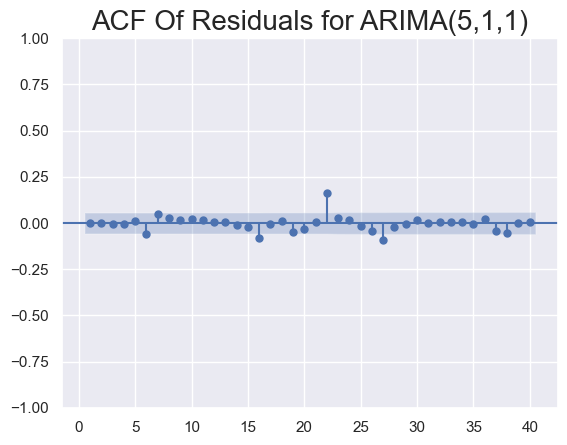

In [31]:
# Crear una nueva columna 'res_ar_5_i_1_ma_1' en el DataFrame 'df' y asignar los residuos del modelo ARIMA(5,1,1) a esa columna
df['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid
# Generar un gráfico de la función de autocorrelación (ACF) de los residuos, excluyendo el rezago en el índice 0
# con un máximo de 40 rezagos.
sgt.plot_acf(df.res_ar_5_i_1_ma_1[1:], zero = False, lags = 40)
# Establecer el título del gráfico
plt.title("ACF Of Residuals for ARIMA(5,1,1)", size=20)
# Mostrar el gráfico
plt.show()

## Models with Higher Levels of Integration

In [32]:
#El código se utiliza para crear una nueva columna en el DataFrame, esta columna almacena la diferencia de primer orden entre 02 valores de la columna, es decir, contendrá las variaciones diarias en los precios de la variable 'market_value'
df['delta_prices']=df.market_value.diff(1)

In [33]:
#El comando crea un modelo ARIMA para analizar la serie de tiempo de las diferencias diarias en los precios ('delta_prices') almacenadas en df. 
model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1,0,1))
#Se ajusta el modelo ARIMA a los datos de la serie de diferencias diarias
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
#El comando genera un resumen del modelo ajustado, que proporciona información sobre los parámetros estimados.
results_delta_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 1198
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8065.014
Date:                Fri, 13 Oct 2023   AIC                          16138.028
Time:                        15:11:11   BIC                          16158.381
Sample:                    03-13-2018   HQIC                         16145.696
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2722      1.324      0.206      0.837      -2.323       2.867
ar.L1          0.6490      0.019     33.397      0.000       0.611       0.687
ma.L1         -0.9256      0.011    -84.060      0.000      -0.947      -0.904
sigma2      4.118e+04    552.166     74.578      0.000    4.01e+04    4.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):             33991.50
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
#El comando se utiliza para realizar la prueba de Dickey-Fuller aumentada en una serie de tiempo de las diferencias diarias de los precios
sts.adfuller(df.delta_prices[1:])

(-10.84020396707081,
 1.6232312300435712e-19,
 21,
 1176,
 {'1%': -3.4359228156852093,
  '5%': -2.8640008242280555,
  '10%': -2.5680801943923828},
 15816.453434102365)

In [35]:
#Describe un modelo ARIMA (1,2,1) 
model_ar_1_i_2_ma_1 = ARIMA(df.market_value, order=(1,2,1))
#Ajusta el modelo ARIMA a tus datos utilizando el método
results_ar_1_i_2_ma_1 = model_ar_1_i_2_ma_1.fit()
#Muestra un resumen de los resultados del ajuste del modelo ARIMA
results_ar_1_i_2_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -8128.839
Date:                Fri, 13 Oct 2023   AIC                          16263.679
Time:                        15:11:12   BIC                          16278.941
Sample:                    03-12-2018   HQIC                         16269.429
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1193      0.015     -8.176      0.000      -0.148      -0.091
ma.L1         -0.9995      0.064    -15.715      0.000      -1.124      -0.875
sigma2      4.591e+04   2949.858     15.565      0.000    4.01e+04    5.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):             41814.11
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

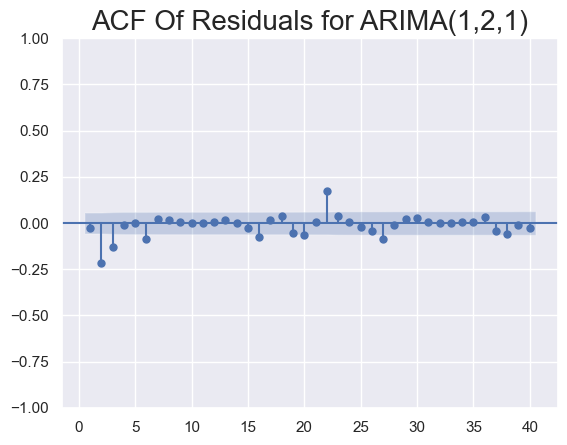

In [36]:
#Crea una nueva columna y lo completa con los residuos del modelo ARIMA(1,2,1) ajustados previamente.
df['res_ar_1_i_2_ma_1'] = results_ar_1_i_2_ma_1.resid.iloc[:]
#Calcula y traza la función de autocorrelación (ACF) de los residuos del modelo ARIMA
sgt.plot_acf(df.res_ar_1_i_2_ma_1[2:], zero = False, lags = 40)
#Establece un título para el gráfico de la función de autocorrelación de los residuos
plt.title("ACF Of Residuals for ARIMA(1,2,1)",size=20)
#Muestra el gráfico de la ACF de los residuos.
plt.show()

## ARIMAX 

In [37]:
#El código crea un objeto de modelo ARIMA con un componente autorregresivo, un componente de diferenciación y un componente de media movil
model_ar_1_i_1_ma_1_Xspx = ARIMA(df.market_value, exog=df['spx '], order=(1,1,1))
#Se ajusta el modelo ARIMA a los datos utilizados.
results_ar_1_i_1_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()
#Muestra un resumen detallado de los resultados del modelo ajustado.
results_ar_1_i_1_ma_1_Xspx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7913.635
Date:                Fri, 13 Oct 2023   AIC                          15835.271
Time:                        15:11:13   BIC                          15855.625
Sample:                    03-12-2018   HQIC                         15842.939
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            0.6394      0.018     35.353      0.000       0.604       0.675
ar.L1          0.6677      0.021     31.953      0.000       0.627       0.709
ma.L1         -0.9239      0.011    -82.551      0.000      -0.946      -0.902
sigma2      3.198e+04    346.256     92.361      0.000    3.13e+04    3.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):             72021.88
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [39]:
#El código crea un modelo SARIMAX según los argumentos d ela serie de tiempo, la variable exógena de la columna 'spx ', los componentes no estacional del modelo SARIMA (2,0,1,5)
model_sarimax = SARIMAX(df.market_value, exog=df['spx '], order=(1,0,1), seasonal_order=(2,0,1,5))
#El código ajusta el modelo SARIMAX a los datos utilizando el método 'fit()' y almacena los resultados de la variable 'results_sarimax'
results_sarimax = model_sarimax.fit()
#El código muestra un resumen detallado de los resultados del modelo SARIMAX ajustado, incluyendo estadísticas, coeficientes y diagnósticos del modelo.
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 1199
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood               -7976.390
Date:                           Fri, 13 Oct 2023   AIC                          15966.779
Time:                                   15:11:18   BIC                          16002.404
Sample:                               03-12-2018   HQIC                         15980.200
                                    - 10-13-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            0.6634      0.017     39.755      0.000       0.631       0.696
ar.L1          1.0000      0.006    159.924      0.000       0.988       1.012
ma.L1         -0.2302      0.011    -21.099      0.000      -0.252      -0.209
ar.S.L5        0.9287      0.090     10.375      0.000       0.753       1.104
ar.S.L10       0.0712      0.023      3.106      0.002       0.026       0.116
ma.S.L5       -1.0000      0.084    -11.966      0.000      -1.164      -0.836
sigma2      3.868e+04   1.76e-05    2.2e+09      0.000    3.87e+04    3.87e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.73   Jarque-Bera (JB):             67319.22
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               2.55   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.12e+23. Standard errors may be unstable.
"""